In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
# Upload Kaggle API key file
uploaded = files.upload()

In [ ]:
# Create a directory for Kaggle configuration

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Set the Kaggle configuration directory environment variable
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [00:13<00:00, 186MB/s]
100% 2.13G/2.13G [00:13<00:00, 165MB/s]


In [ ]:
# Unzip the downloaded datasets
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [5]:
# Path of the Dataset
dataset_path="/content/leapGestRecog"

# Gesture categories (same as before)
categories = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
              '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']

# Image size to resize
image_size = 128

def load_images_from_folder(dataset_path, categories, image_size):
  images = []
  labels = []

  for subject in range(10): # For subjects 00 to 09
    subject_path = os.path.join(dataset_path,f"{subject:02d}")

    for category in categories:
      category_path = os.path.join(subject_path,category)
      label = categories.index(category)  # Assign a label based on folder name

      for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is not None: # Ensure images is loaded
          image= cv2.resize(image,(image_size,image_size))
          images.append(image)
          labels.append(label)

  images= np.array(images).reshape(-1,image_size,image_size,1)/255 # Normalize
  labels= np.array(labels)

  return images, labels

# load the dataset
images, labels = load_images_from_folder(dataset_path,categories, image_size)

# convert labels to one-hot encoding
labels= to_categorical(labels, num_classes=len(categories))

# Split into training and test sets
X_train, X_test, Y_train, Y_test=train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')


Training samples: 16000, Testing samples: 4000


In [6]:
def build_gesture_cnn(input_size=(128, 128, 1)):

  # Defining the number of filters for each layer
  filters = [32,64,128]

  model = Sequential()

  # Convolutional Layers
  model.add(Conv2D(filters[0],(3,3),activation='relu',input_shape=input_size))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters[1],(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters[2],(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(len(categories), activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model


gesture_cnn=build_gesture_cnn()
gesture_cnn.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,354 (12.61 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from time import time


# Record the current time to measure training time
tic = time()

#Fir the mdoel on the training data
history = gesture_cnn.fit(X_train, Y_train,validation_data=(X_test, Y_test), batch_size=64, epochs=3)

# Record the time after model training
toc = time()

# Save the model in the specified location
gesture_cnn.save('/content/my_model.keras')

# Calculate and print the time taken for model training
print(f"Model training took {toc - tic } secs")

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.6900 - loss: 0.8912 - val_accuracy: 0.9977 - val_loss: 0.0118
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.9862 - loss: 0.0431 - val_accuracy: 0.9980 - val_loss: 0.0042
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.9923 - loss: 0.0230 - val_accuracy: 0.9987 - val_loss: 0.0060
Model training took 1677.474401473999 secs


In [8]:
# Evaluate the model on test data
test_loss, test_acc = gesture_cnn.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.9985 - loss: 0.0056
Test Accuracy: 0.9987, Test Loss: 0.0060


125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step


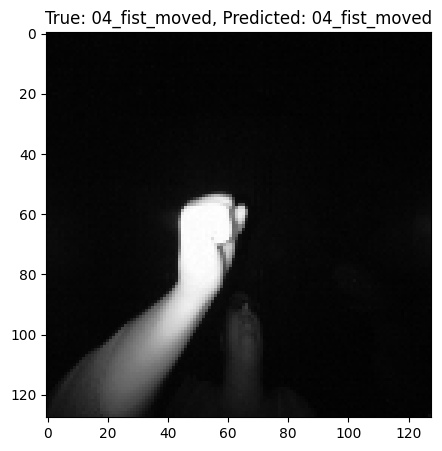

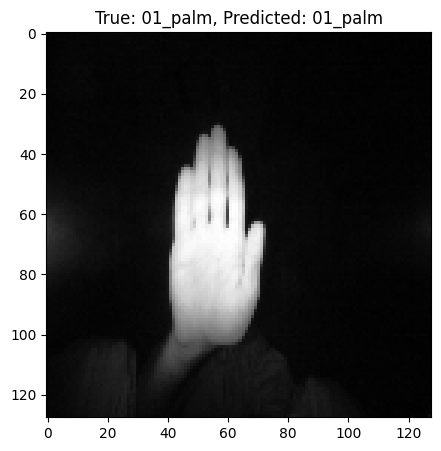

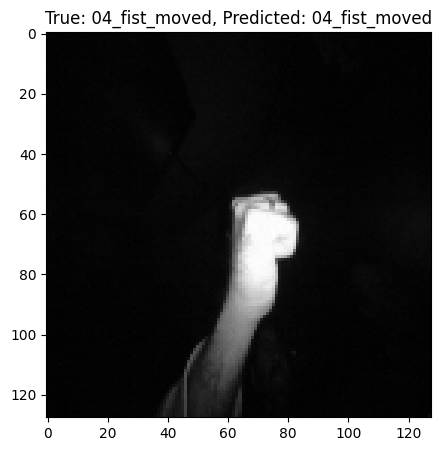

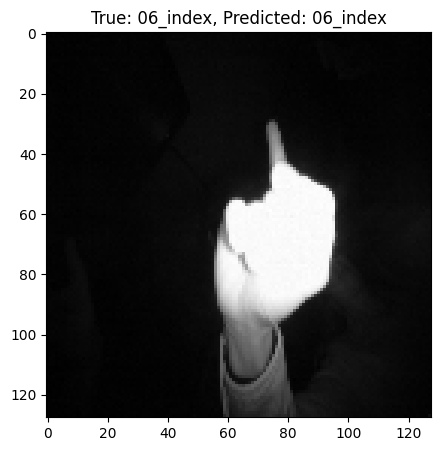

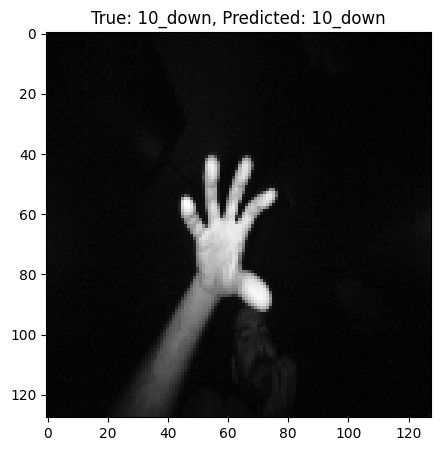

In [9]:
# Predictions on the test images
pridictions = gesture_cnn.predict(X_test)

# Function to display predictions
def display_predictions(X_test, predictions, Y_test):
  for i in range(5):
    plt.figure(figsize=(5,5))

    plt.imshow(X_test[i].reshape(image_size,image_size),cmap='gray')
    plt.title(f"True: {categories[np.argmax(Y_test[i])]}, Predicted: {categories[np.argmax(predictions[i])]}")
    plt.show()


display_predictions(X_test, pridictions, Y_test)

In [10]:
# Download the model
files.download('/content/my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>